# K-Means w/ PCA on Pneumonia X-Rays

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import time

In [2]:
from sklearn.preprocessing import normalize

In [3]:
#Helper function to get cluster_plot
def get_cluster_plot(rows, Kmus): 
    '''
    : get a plot of what different clusters represent
    : takes as input the cluster location matrix
    '''
    fig,axs = plt.subplots(rows,5, figsize = (15,9))
    for i in range(len(Kmus)):
        cluster = Kmus[i].reshape(256,-1) * 255
        axs[i//5][i%5].imshow(cluster, cmap = plt.cm.binary)
        axs[i//5][i%5].set_title(f'Cluster {i + 1}')

## Setup: Reading and formatting images

The data used in this notebook consist of lung x-rays from healthy individuals and individuals infected with pneumonia. Although the data comes with the identifying labels, we will remove them in order to create an unlabeled dataset. Images will also be resized to 256x256.

In [4]:
#Function to process .jpeg images into array for KMeans
def process_imgKMeans():
    print("Reading images for KMeans")
    array = []
    labelled = []
    dim = (256, 256)
    images = glob.glob("./chest_xray/train/NORMAL/*.jpeg")
    for image_file in images:
        # Resize images and remove RGB
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        array.append(image)
        labelled.append("NORMAL")

    images = glob.glob("./chest_xray/train/PNEUMONIA/*.jpeg")
    for image_file in images:
        # Resize images and remove RGB
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        array.append(image)
        labelled.append("PNEUMONIA")

    return array, labelled

In [5]:
#Function to process .jpeg images into array for PCA
def process_imgPCA():
    print("Reading images for PCA")
    array = []
    labelled = []
    dim = (256, 256)
    images = glob.glob("./chest_xray/train/NORMAL/*.jpeg")
    for image_file in images:
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).T
        array.append(image)
        labelled.append("NORMAL")

    images = glob.glob("./chest_xray/train/PNEUMONIA/*.jpeg")
    for image_file in images:
        image = cv2.resize(cv2.imread(image_file), dim, interpolation = cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).T
        array.append(image)
        labelled.append("PNEUMONIA")
    
    return array, labelled

In [6]:
#processing images
x_raysKMeans, labelled_K = process_imgKMeans()
x_raysPCA, labelled_PCA = process_imgPCA()

Reading images for KMeans
Reading images for PCA


In [7]:
#convert to arrays
x_raysKMeans, labelled_K = np.array(x_raysKMeans), np.array(labelled_K)
x_raysPCA, labelled_PCA = np.array(x_raysPCA), np.array(labelled_PCA)

## Visualizing the data:

We can plot images of healthy lungs and infected lungs to visualize the difference between both.

<ipython-input-8-fcb80072e64d>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


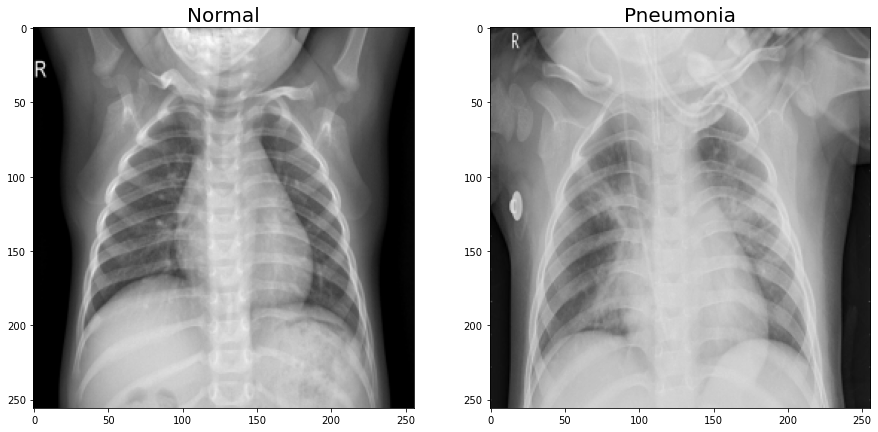

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,9))
axs[0].set_title("Normal", fontsize="20")
axs[0].imshow(x_raysKMeans[2].reshape(256,256), cmap=plt.get_cmap('gray'))
axs[1].set_title("Pneumonia", fontsize="20")
axs[1].imshow(x_raysKMeans[-2].reshape(256,256), cmap=plt.get_cmap('gray'))

fig.show()

From the images above, we can clearly see that lungs with pneumonia look more cloudy than healthy lungs. When observing the images, the cloudiness of the lungs are a common difference between normal and infected lungs.

In [9]:
#shuffle
np.random.seed(42)
np.random.shuffle(labelled_K)
np.random.seed(42)
np.random.shuffle(labelled_PCA)
np.random.seed(42)
np.random.shuffle(x_raysKMeans)
np.random.seed(42)
np.random.shuffle(x_raysPCA)

In [10]:
#Reshape array to 1D nparray
x_raysKMeans = x_raysKMeans.reshape(5216, -1)/255

In [11]:
#Reshape array to 1D nparray and take transpose to create column vectors
x_raysPCA = x_raysPCA.reshape(5216, -1)/255
x_raysPCA = x_raysPCA.T

## K-means:

Using K-means, we can attempt to find some underlying patterns for our images by assigning our images to certain clusters. We know that the dataset contains x-rays of both healthy and infected lungs and from the visualization, we can clearly see a difference in cloudiness. So we can train our model to try and identify this difference.

In [12]:
#Helper functions for KMeans
def calcSqDistances(X, Kmus):
    res = np.zeros((X.shape[0], Kmus.shape[0]))
    for i in range(X.shape[0]):
        for j in range(Kmus.shape[0]):
            res[i, j] = np.linalg.norm(X[i] - Kmus[j])
    return res

def determineRnk(sqDmat):
    Rnk = np.tile(0, (sqDmat.shape[0], sqDmat.shape[1]))
    for i in range(sqDmat.shape[0]):
        index = np.argmin(sqDmat[i])
        Rnk[i][index] = 1
    
    return Rnk

def recalcMus(X, Rnk):
    recalc = np.zeros((Rnk.shape[1], X.shape[1]))
    
    for i in range(Rnk.shape[1]):
        recalc[i,:] = np.sum((np.array([Rnk[:,i]]).T) * X, axis = 0)/(np.sum(Rnk[:,i], axis = 0))
    return recalc

In [13]:
def runKMeans(matrix, K):
    #load data file specified by fileString from Bishop book
    start = time.time()
    X = matrix

    #determine and store data set information
    N, D = X.shape

    #allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    #initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]

    #specify the maximum number of iterations to allow
    maxiters = 1000

    for iter in range(maxiters):
        #assign each data vector to closest mu vector as per Bishop (9.2)
        #do this by first calculating a squared distance matrix where the n,k entry
        #contains the squared distance from the nth data vector to the kth mu vector

        #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus)

        #given the matrix of squared distances, determine the closest cluster
        #center for each data vector

        #R is the "responsibility" matrix
        #R will be an N-by-K matrix of binary values whose n,k entry is set as
        #per Bishop (9.2)
        #Specifically, the n,k entry is 1 if point n is closest to cluster k,
        #and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
#         plotCurrent(X, Rnk, Kmus)
#         time.sleep(1)

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)





        #check to see if the cluster centers have converged.  If so, break.
        diff = np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1))))
        print(diff)
        if diff < 1e-6:
            print(iter)
            break

    # plotCurrent(X, Rnk, Kmus)
    end = time.time()
    seconds = end - start
    print(f"Total time: {seconds}")
    return Kmus, Rnk, seconds

Running K-means for 2 clusters

In [14]:
xray_kmeans, kmeans_rnk, s = runKMeans(x_raysKMeans, 2)

11825.222099573164
3008.9462180003316
1642.6832043562986
1255.1272359638415
939.4602728275682
749.006161177396
532.7144261709693
360.02911756802627
266.8240875684195
180.98729010070366
123.78849450023655
77.91426555743783
44.086618720447674
29.463838296749046
28.36458368456325
29.19312341996852
21.007270574470546
16.065880737134272
19.16149515037721
8.115370011189102
6.30284631291923
6.144175072234256
0.0
22
Total time: 83.12956619262695


## Results from K-means:

We can try to cluster K-means with 2 clusters (normal and pneumonia).

In [15]:
print(xray_kmeans)

[[0.16432235 0.16936925 0.1895628  ... 0.06146962 0.06321931 0.07046931]
 [0.21677999 0.22662194 0.24557264 ... 0.07848309 0.07943078 0.08672934]]


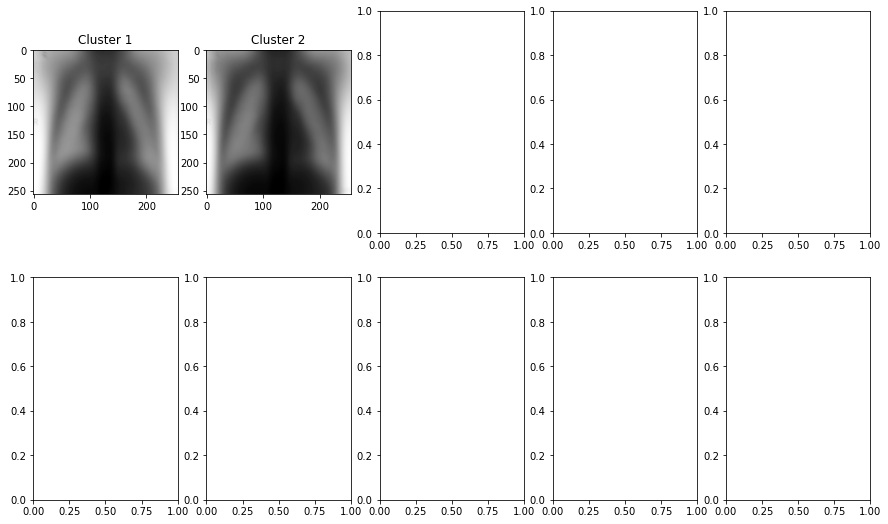

In [16]:
get_cluster_plot(2, xray_kmeans)

<ipython-input-17-61d233dc05b2>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


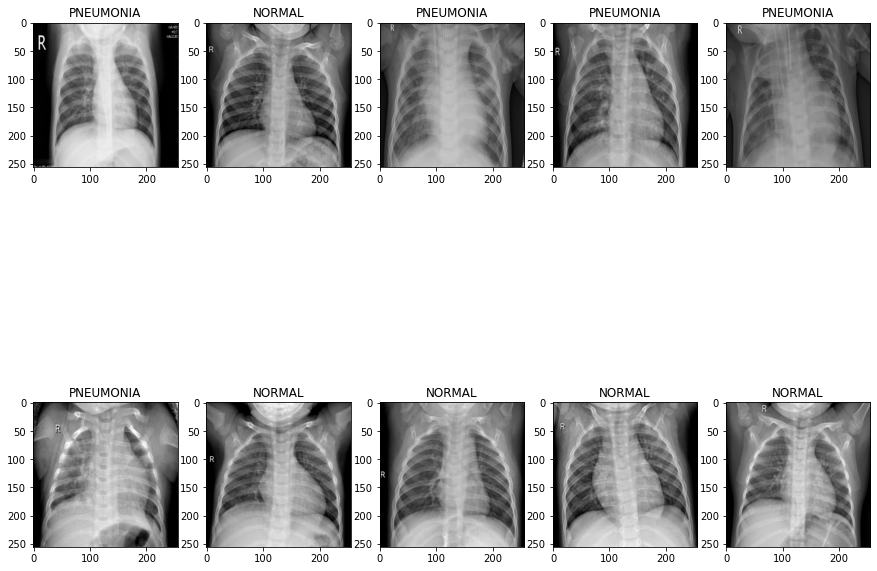

In [17]:
def get_indices(rnk, num_indices):
    
    indices = []
    clusters = rnk.shape[1]
    for i in range(clusters):
      indices.append([])

    i = 0
    j = 0
    while i < num_indices*clusters:
        val = max(rnk[j])
        pos = np.where(rnk[j] == val)[0][0]
        if (len(indices[pos]) != 5):
            indices[pos].append(j)
            i += 1

        j += 1
        
    return indices

indices = get_indices(kmeans_rnk, 5)

def view_images(indices, labelled, imgs):
    clusters = len(indices)
    num_images = len(indices[0])
    fig, axs = plt.subplots(clusters, num_images, figsize=(15,9))
    for col in range(num_images):
        for i in range(clusters):
            axs[i][col].set_title(f"{labelled[indices[i][col]]}", fontsize="12")
            axs[i][col].imshow(imgs[indices[i][col]].reshape(256,256), cmap=plt.get_cmap('gray'))
            
    plt.subplots_adjust(top=1.2)
    fig.show()
    
view_images(indices, labelled_K, x_raysKMeans)

4 clusters.

In [18]:
four_clusters, kmeans_rnk, four_s = runKMeans(x_raysKMeans, 4)

19166.03819423348
4010.387221820608
2129.2220562755683
1832.1460963604222
1659.7686910878094
1313.2757329192593
1011.3730002878061
853.9484204876736
736.5084566034514
727.6523912564514
659.99320859277
480.9496192330572
419.0751550177804
363.415452290223
269.0652018535588
250.0572733854947
180.43683918608195
143.26005378001693
162.89563203372634
182.2843208137841
208.12104354267237
256.6800084052528
231.4948516680328
204.4785787768475
258.1272592213611
288.7620645949463
415.3647821117936
455.9548296849162
428.1334377835815
496.30193659346963
445.0444236434921
451.9742374446546
345.46500856565234
342.7502680767705
356.1811900033251
344.45415557211373
289.597967995169
253.8196702722762
198.68621527444748
175.0011497794833
172.98221222017048
174.6048374811216
132.4452916809501
104.5451485018728
98.50341693852391
101.53936888040533
70.42389290732774
60.15392433503774
71.2692313927587
45.30044833159605
39.52252168796203
31.808952544567852
23.954965328209415
42.80150099479387
57.3195745584652

<ipython-input-17-61d233dc05b2>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


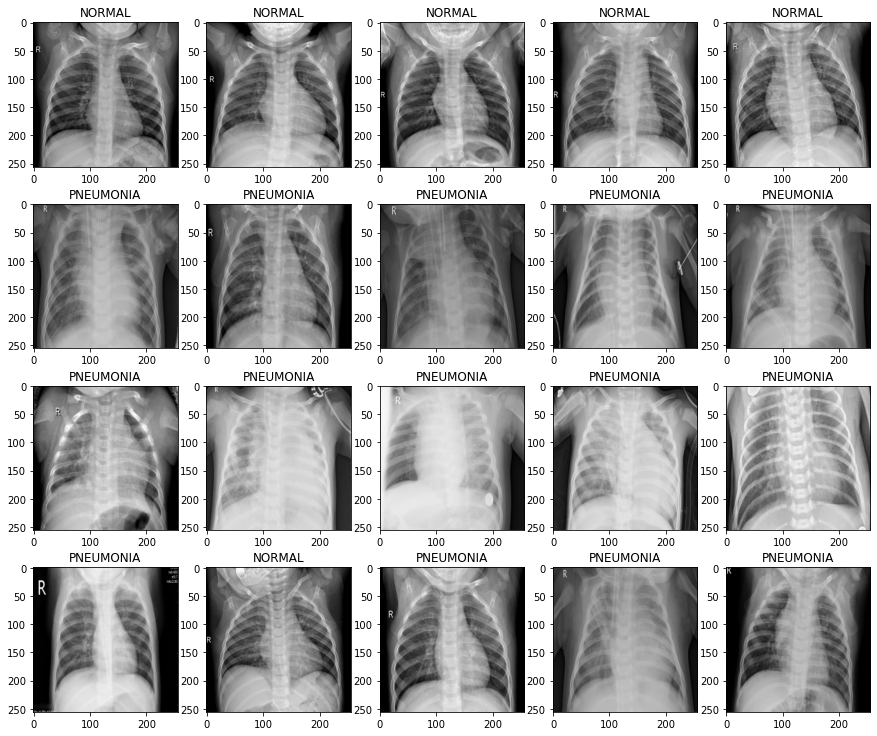

In [19]:
indices = get_indices(kmeans_rnk, 5)
view_images(indices, labelled_K, x_raysKMeans)

## PCA:


In [20]:
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort, lambd

#Helper function to normalize matrix

def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

#Helper function to plot skree plot of lambdas

def skree(lambd):
    plt.plot(np.arange(len(lambd)) + 1, lambd, 'ro-', linewidth = 2)
    plt.title("Scree Plot")
    plt.xlabel("Principal Component")
    plt.ylabel("Eigenvalue")
    return

#Helper function to return variance explained and cumulataive sum of variance

def explained_variance(eigen_values):

  #explains how much of the data each component describes 
    var_exp = [(i/sum(eigen_values))*100 for i in eigen_values]
  
  #cumsum of var_exp for easier visualization
    cumsum_var = np.cumsum(var_exp)

    return var_exp, cumsum_var

#Helper function to viewcolumn vectors

def viewcolumn(columnvector):
    plt.imshow(columnvector.reshape(
        [256, 256], order='F'), cmap=plt.get_cmap('gray'))
    plt.show()

#Helper function to retrive indice where threshold variance is explained
#e.g. returns i = 4 if first 5 components explain threshold variance

def indexfinder(cumsum, threshold):
    for i in range(len(cumsum)):
        if cumsum[i] >= threshold:
            return i

In [21]:
x_raysPCA.shape

(65536, 5216)

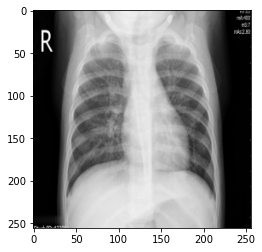

In [22]:
viewcolumn(x_raysPCA[:,0])

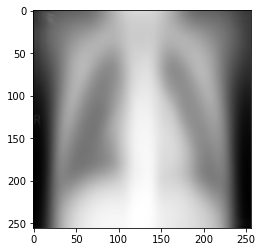

In [23]:
mean_xrays = np.mean(x_raysPCA, axis = 1)[:,None]
viewcolumn(mean_xrays)

In [24]:
A = (x_raysPCA - mean_xrays).real.astype(np.float32)
cov = np.divide(A.T@A, 5216)

In [25]:
eigvals, V = np.linalg.eig(cov)
Vsort, Dsort, lambd = eigsort(V, eigvals)

<ipython-input-20-b1edd943f5b5>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  Vsort[:,i] = V[:,index[i]]


In [26]:
U = A @ Vsort
U = normc(U)

C:\Users\wilso\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


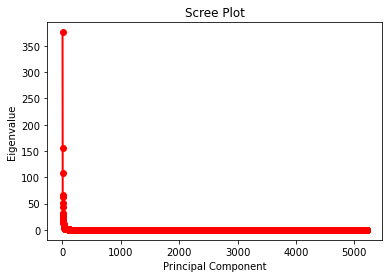

In [27]:
#Skree plot
#Elbow at near right angle, extreme drop off of variance explained by components 
#following elbow
skree(lambd)

In [28]:
exp, cumsum = explained_variance(eigvals)
cumsum

array([ 25.24716782+0.j,  35.67791557+0.j,  42.91349135+0.j, ...,
        99.99959961+0.j,  99.99979735+0.j, 100.        +0.j])

In [43]:
indexfinder(cumsum, 96)

647

In [30]:
reduced_U = U[:625]
x_rays_temp = x_raysPCA[:,:625] - mean_xrays

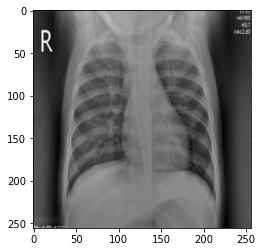

(65536, 625)

In [31]:
viewcolumn(x_rays_temp[:,0])
reduced_U.shape
x_rays_temp.shape

In [32]:
reduced_xrays = reduced_U.T @ x_rays_temp[:625]

In [33]:
zhat = U[:,:625] @ reduced_xrays[:625] + mean_xrays

In [34]:
#shape comparisons
reduced_xrays.shape, x_raysPCA.shape, zhat.shape

((5216, 625), (65536, 5216), (65536, 625))

## K-means with PCA:

We saw that K-means for 2 clusters was okay, but what about K-means with PCA for 2 clusters?

In [35]:
#KMeans on PCA reduced xrays, significantly faster
reduced_test, red_rnk, red_s = runKMeans(reduced_xrays, 2)

19.884615837857066
5.974127837176934
12.394317317669604
28.503498592039463
49.02149636535173
52.84112852684317
44.18897391953078
47.37062178268144
29.691420597044612
40.99545604235713
18.304230350958903
10.14399535215067
12.376978144306014
11.698716059392186
0.0
14
Total time: 2.1441211700439453


In [36]:
print(reduced_test.shape)

(2, 625)


<ipython-input-17-61d233dc05b2>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


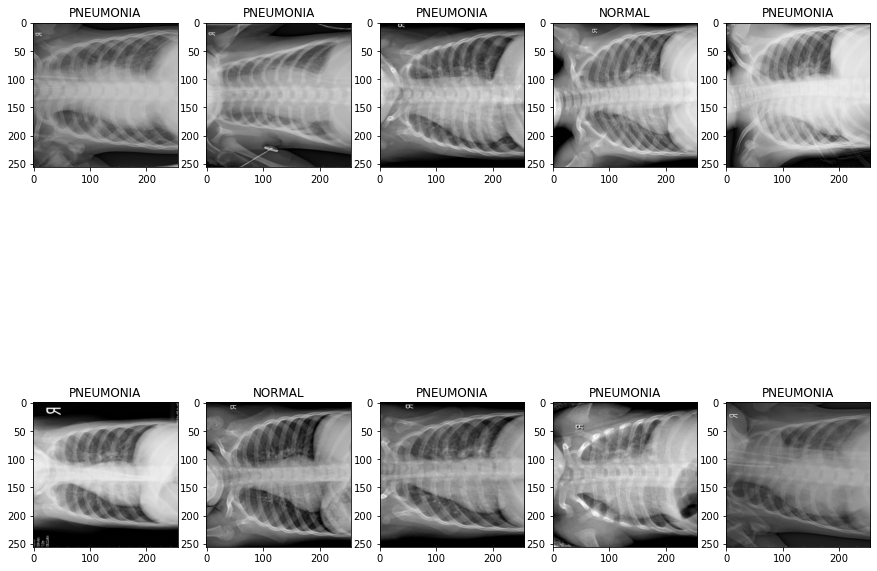

In [37]:
#cluster1, cluster2
indices = get_indices(red_rnk, 5)
view_images(indices, labelled_PCA, x_raysPCA.T)

## Comparing Runtime for K-means w/ and w/o PCA

In [38]:
#Time test
runKMeans(x_raysKMeans[:625], 10)

44051.174380795994
8466.605820776504
4281.688568880296
2532.732232962998
2653.9205704544447
1672.0300559932
1069.7203031209267
692.6059599789389
1000.7965595812312
1547.888503274494
951.3661447120003
1579.1893751180405
1497.1017220934937
732.3503274341582
850.8311804752203
390.13622194783653
554.038865345623
777.3098494972531
919.1872055367569
1013.3462962673613
848.7454580188459
689.1805634689018
496.37766939420163
604.7935134452382
392.19594507171644
273.8788880393968
0.0
26
Total time: 58.35050368309021


(array([[0.18367201, 0.17611408, 0.17590018, ..., 0.06923351, 0.07557932,
         0.09019608],
        [0.03945336, 0.05264409, 0.12774807, ..., 0.00689245, 0.00724896,
         0.00998217],
        [0.30917141, 0.30657812, 0.30562935, ..., 0.14054396, 0.14781784,
         0.16932321],
        ...,
        [0.24254902, 0.2645098 , 0.27196078, ..., 0.02764706, 0.02426471,
         0.0220098 ],
        [0.26336757, 0.2648615 , 0.28173047, ..., 0.17335823, 0.17684407,
         0.17976969],
        [0.21018937, 0.20046925, 0.19463717, ..., 0.1040724 , 0.10668678,
         0.11208312]]),
 array([[0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 58.35050368309021)

In [39]:
runKMeans(reduced_xrays, 10)

140.75684692622477
136.51832127552507
138.31109548878834
111.23763482380271
96.90658751152759
91.8229168526283
75.93351477527497
93.62927821878472
77.83510817858968
70.31773965687853
69.54560282560965
71.29806824344956
49.04718052384979
24.223385088032497
13.3123671811179
11.427831556551657
17.01580208079443
11.264683635069565
14.61411251032683
53.82629555120723
9.259985855196987
11.59761108727315
3.9472487737296245
6.124307833993336
5.325252135033793
6.005876436794939
2.627768631871035
5.0373894475587315
1.6693710804391653
1.9777122977347048
0.7946282869553414
0.17396868363787032
0.01449964933734478
0.009420160173033765
0.005645378499045656
0.0062816683178957555
0.010080985802614396
0.005101187709106872
0.0
38
Total time: 18.706010818481445


(array([[-8.13850763e-03, -8.96267778e-03, -2.52906656e-04, ...,
         -7.32388726e-03, -5.52687916e-03, -7.99264684e-03],
        [ 3.75052235e-02,  5.21685485e-02,  1.76321719e-02, ...,
          4.93305106e-02,  1.65669132e-01,  8.56583977e-02],
        [ 8.45756474e-03,  9.30752262e-03,  6.18706928e-04, ...,
          6.97516870e-03,  7.91812246e-03,  9.79724197e-03],
        ...,
        [ 2.57653837e-01,  2.84435516e-01, -3.55365644e-02, ...,
          2.75136736e-01,  7.36622577e-02,  2.15077906e-01],
        [-8.35103543e-02, -8.26871846e-02,  2.85120923e-02, ...,
         -7.04538320e-02,  6.57794758e-02, -3.81443236e-02],
        [ 6.65701258e-01,  7.42641769e-01, -6.03014457e-02, ...,
          7.05176645e-01,  2.48314344e-01,  5.70941307e-01]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 0]]),
 18.706010818481

In [40]:
normal_times, reduced_times = [], []
for k in range(2, 16):
    mus, rnk, s = runKMeans(x_raysKMeans[:625], k)
    normal_times.append(s)
    rmus, rrnk, rs = runKMeans(reduced_xrays, k)
    reduced_times.append(rs)

12651.292767926943
1907.5697918115352
1790.5591706975865
1166.2602066178958
836.4675910500702
652.8369216613859
425.13793288011857
390.94438243336754
194.68748598437475
168.7364747910567
134.28384970117924
181.98382665988026
59.45576853765156
45.11007116136612
46.044013185690005
48.32631393021774
42.28009436826929
0.0
17
Total time: 8.947791576385498
32.79691117409951
34.16157024438756
36.388880847172295
26.34190349102309
16.504806047780125
10.818538070435022
4.48452407249703
3.0245178646620947
1.4851838088189715
0.0
9
Total time: 1.07666015625
15336.558095796183
3545.280412632115
1836.9263831340816
1006.2049564728346
511.28975613406993
389.6038244669466
315.0066149337264
238.66149459694867
122.90526572534819
155.774826847824
0.0
10
Total time: 7.443486213684082
62.70722480879217
51.75750836832886
50.57374317196418
55.80921349519974
69.83627340436317
58.64619457537761
38.49814191641672
38.89254679736907
36.7600993674263
38.33853524313035
19.249612060219025
12.377071856768055
11.6988250

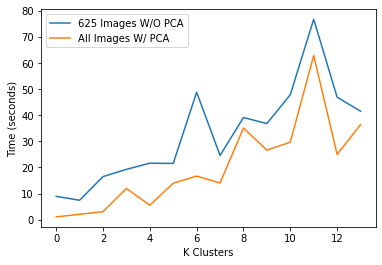

In [41]:
plt.plot(normal_times, label = "625 Images W/O PCA")
plt.plot(reduced_times, label = "All Images W/ PCA")
plt.xlabel("K Clusters")
plt.ylabel("Time (seconds)")
plt.legend()

So, not only was it able to cluster the images to 2 clusters, but it also (on average) runs faster.